# Home Court Advantage Analysis

In this Notebook, we will conduct analysis on whether home court advantage exists in the NBA. We will use the `team_statistics.csv` dataset to analyze the statistics of home and away games.

<b> For this purpose, we have asked us the following questions: </b>
- Does the home team win more often than the away team?
- Do the referees call fewer fouls on the home team (i.e. the home team gets more free throws than the away team)?
- If the home team wins, does it win by a larger margin than if the away team wins?
- Does the home team score on a higher percentage (FG%, FT%, 3P%) than the away team?

## Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import yaml
from IPython.display import Markdown, display

In [5]:
# load yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    DATA_PATH = config.get("data_path")
    if DATA_PATH is None:
        print("ERROR: No data path provided")
    USE_DRIVE = bool(config.get("use_drive", False))

In [6]:
# load from drive if requested
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA

In [7]:
team_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "team_statistics.csv"))
team_statistics_df.info()
team_statistics_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91649 entries, 0 to 91648
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   91649 non-null  int64  
 1   gameDate                 91649 non-null  object 
 2   teamCity                 91649 non-null  object 
 3   teamName                 91649 non-null  object 
 4   teamId                   91649 non-null  int64  
 5   opponentTeamCity         91649 non-null  object 
 6   opponentTeamName         91649 non-null  object 
 7   opponentTeamId           91649 non-null  int64  
 8   home                     91649 non-null  int64  
 9   win                      91649 non-null  int64  
 10  teamScore                91649 non-null  int64  
 11  opponentScore            91649 non-null  int64  
 12  assists                  91645 non-null  float64
 13  blocks                   91632 non-null  float64
 14  steals                

,gameId,gameDate,teamCity,teamName,teamId,opponentTeamCity,opponentTeamName,opponentTeamId,home,win,...,biggestScoringRun,leadChanges,pointsFastBreak,pointsFromTurnovers,pointsInThePaint,pointsSecondChance,timesTied,timeoutsRemaining,seasonWins,seasonLosses
0,22401058,2025-03-26 22:00:00,Boston,Celtics,1610612738,Phoenix,Suns,1610612756,0,1,...,15.0,0.0,9.0,16.0,44.0,17.0,0.0,1.0,54.0,19.0
1,22401058,2025-03-26 22:00:00,Phoenix,Suns,1610612756,Boston,Celtics,1610612738,1,0,...,10.0,0.0,9.0,7.0,36.0,16.0,0.0,1.0,35.0,38.0
2,22401057,2025-03-26 21:00:00,Denver,Nuggets,1610612743,Milwaukee,Bucks,1610612749,1,1,...,9.0,2.0,20.0,18.0,64.0,16.0,4.0,1.0,46.0,28.0
3,22401057,2025-03-26 21:00:00,Milwaukee,Bucks,1610612749,Denver,Nuggets,1610612743,0,0,...,7.0,2.0,5.0,17.0,56.0,13.0,4.0,0.0,40.0,32.0
4,22401054,2025-03-26 19:30:00,Brooklyn,Nets,1610612751,Toronto,Raptors,1610612761,1,0,...,8.0,0.0,12.0,7.0,46.0,12.0,1.0,1.0,23.0,50.0


Since we want to analyze home court advantage, we need a dataset for both only home and only away games

In [8]:
drop_columns = ["gameDate", "teamCity", "teamName", "teamId", "opponentTeamCity", "opponentTeamName", "opponentTeamId"]
home_court_advantage_df = team_statistics_df.drop(columns=drop_columns)

home_statistics_df = home_court_advantage_df[home_court_advantage_df["home"] == True]
away_statistics_df = home_court_advantage_df[home_court_advantage_df["home"] == False]
home_court_advantage_df.head()

# Only select rows where the gameId exists in both home and away games
home_statistics_df = home_statistics_df[home_statistics_df["gameId"].isin(away_statistics_df["gameId"])]
away_statistics_df = away_statistics_df[away_statistics_df["gameId"].isin(home_statistics_df["gameId"])]
home_court_advantage_df = home_court_advantage_df[home_court_advantage_df["gameId"].isin(home_statistics_df["gameId"])]
home_statistics_df.drop(columns=["gameId", "home"], inplace=True)
away_statistics_df.drop(columns=["gameId", "home"], inplace=True)
home_statistics_df.reset_index(drop=True, inplace=True)
away_statistics_df.reset_index(drop=True, inplace=True)

First, we perform Summary Statstics on the home and away statistics.

In [15]:
# Summary Statistics:
print(home_statistics_df.describe())

                win     teamScore  opponentScore       assists        blocks  \
count  45542.000000  45542.000000   45542.000000  45540.000000  45534.000000   
mean       0.599776    104.387994     101.185455     23.958103      5.301709   
std        0.489949     13.738733      13.494477      5.570885      2.757361   
min        0.000000     49.000000      53.000000      5.000000      0.000000   
25%        0.000000     95.000000      92.000000     20.000000      3.000000   
50%        1.000000    104.000000     101.000000     24.000000      5.000000   
75%        1.000000    113.000000     110.000000     28.000000      7.000000   
max        1.000000    175.000000     176.000000     51.000000     23.000000   

             steals  fieldGoalsAttempted  fieldGoalsMade  \
count  45427.000000         45542.000000    45542.000000   
mean       7.962247            84.011264       39.160204   
std        3.083661             8.408252        5.840579   
min        0.000000            53.00000

In [10]:
away_statistics_df.describe()

,win,teamScore,opponentScore,assists,blocks,steals,fieldGoalsAttempted,fieldGoalsMade,fieldGoalsPercentage,threePointersAttempted,...,biggestScoringRun,leadChanges,pointsFastBreak,pointsFromTurnovers,pointsInThePaint,pointsSecondChance,timesTied,timeoutsRemaining,seasonWins,seasonLosses
count,45542.000000,45542.000000,45542.000000,45540.000000,45535.000000,45427.000000,45542.000000,45542.000000,45542.000000,45542.000000,...,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000
mean,0.400224,101.185455,104.387994,22.259047,4.699528,7.836529,83.843178,38.082188,0.455020,18.725023,...,10.102326,6.716279,15.316279,17.573953,48.703256,13.969302,4.840930,0.436279,18.235349,18.253023
std,0.489949,13.494477,13.738733,5.345806,2.505350,3.001973,8.447080,5.641289,0.056438,10.816746,...,2.658521,6.058257,6.505152,6.567574,10.740044,5.571107,4.125341,0.496154,12.674828,12.507472
min,0.000000,53.000000,49.000000,4.000000,0.000000,0.000000,55.000000,16.000000,0.239000,1.000000,...,5.000000,0.000000,0.000000,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,92.000000,95.000000,19.000000,3.000000,6.000000,78.000000,34.000000,0.417000,10.000000,...,8.000000,2.000000,10.000000,13.000000,42.000000,10.000000,2.000000,0.000000,7.500000,8.000000
50%,0.000000,101.000000,104.000000,22.000000,4.000000,8.000000,84.000000,38.000000,0.455000,17.000000,...,10.000000,5.000000,15.000000,17.000000,48.000000,13.000000,4.000000,0.000000,16.000000,17.000000
75%,1.000000,110.000000,113.000000,26.000000,6.000000,10.000000,89.000000,42.000000,0.494000,26.000000,...,11.500000,10.000000,19.000000,22.000000,56.000000,18.000000,7.000000,1.000000,26.000000,27.000000
max,1.000000,176.000000,175.000000,52.000000,19.000000,24.000000,129.000000,68.000000,0.687000,63.000000,...,23.000000,42.000000,39.000000,40.000000,84.000000,33.000000,22.000000,1.000000,60.000000,56.000000


In [11]:
home_win_percentage = home_statistics_df["win"].mean()
away_win_percentage = away_statistics_df["win"].mean()
home_margin = home_statistics_df["plusMinusPoints"]
away_margin = away_statistics_df["plusMinusPoints"]

display(Markdown(f"**Home Team Win Percentage:** {home_win_percentage}"))
display(Markdown(f"**Away Team Win Percentage:** {away_win_percentage}"))
display(Markdown(f"**Home Team Margin of Victory:** {home_margin.mean()}"))
display(Markdown(f"**Away Team Margin of Victory:** {away_margin.mean()}"))

**Home Team Win Percentage:** 0.5997760309165167

**Away Team Win Percentage:** 0.4002239690834834

**Home Team Margin of Victory:** 3.3055537182794277

**Away Team Margin of Victory:** -3.0172738763110627

From the summary statistics we can already observe a few key points:
- The home team does win with a higher percentage than the away team.
- The home team does have better statistics in all categories, though we cannot conclude yet if it is significant.

Next up, we will create some plots:

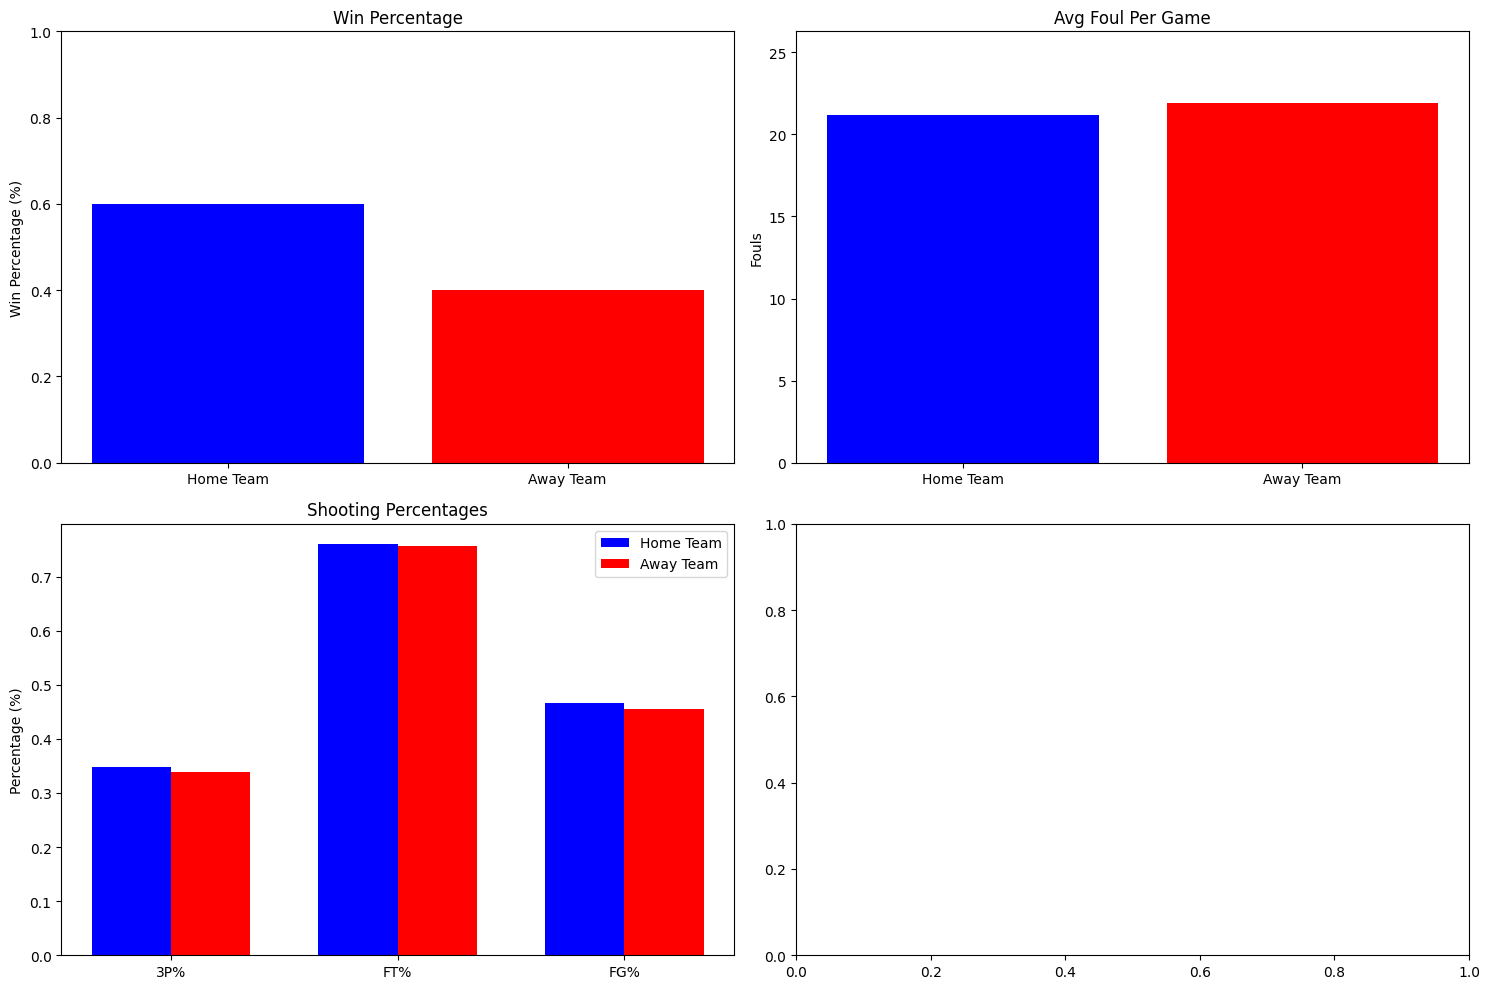

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Win Percentage Plot
axs[0].bar(["Home Team", "Away Team"], [home_win_percentage, away_win_percentage], color=["blue", "red"])
axs[0].set_title("Win Percentage")
axs[0].set_ylabel("Win Percentage (%)")
axs[0].set_ylim(0, 1)

# Foul Calls Plot
foul_home_mean = home_statistics_df["foulsPersonal"].mean()
foul_away_mean = away_statistics_df["foulsPersonal"].mean()
axs[1].bar(["Home Team", "Away Team"], [foul_home_mean, foul_away_mean], color=["blue", "red"])
axs[1].set_title("Avg Foul Per Game")
axs[1].set_ylabel("Fouls")
axs[1].set_ylim(0, max(foul_home_mean, foul_away_mean) * 1.2)

# Percentages Plots
three_home = home_statistics_df["threePointersPercentage"].mean()
three_away = away_statistics_df["threePointersPercentage"].mean()
fg_home = home_statistics_df["fieldGoalsPercentage"].mean()
fg_away = away_statistics_df["fieldGoalsPercentage"].mean()
ft_home = home_statistics_df["freeThrowsPercentage"].mean()
ft_away = away_statistics_df["freeThrowsPercentage"].mean()

categories = ["3P%", "FT%", "FG%"]
home_values = [three_home, ft_home, fg_home]
away_values = [three_away, ft_away, fg_away]
x = np.arange(len(categories))
width = 0.35

axs[2].bar(x - width/2, home_values, width, label='Home Team', color='blue')
axs[2].bar(x + width/2, away_values, width, label='Away Team', color='red')
axs[2].set_title("Shooting Percentages")
axs[2].set_xticks(x)
axs[2].set_xticklabels(categories)
axs[2].set_ylabel("Percentage (%)")
axs[2].legend()

plt.tight_layout()
plt.show()

We do see, that on average, the home team does win more often, and has better statistics in all categories. However, we need to check if this is statistically significant.

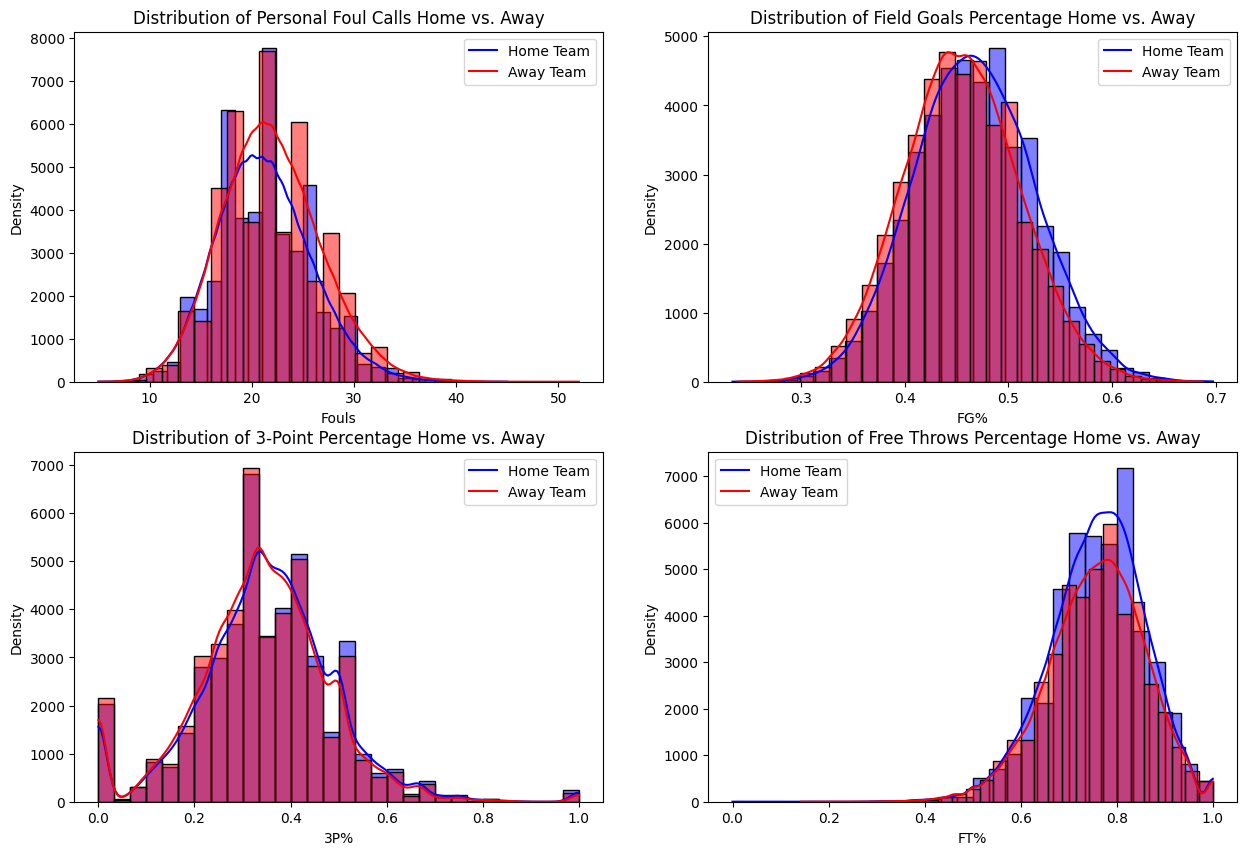

In [13]:
# Plot distributions
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Foul Calls
sns.histplot(home_statistics_df["foulsPersonal"], bins=30, kde=True, color="blue", ax=axs[0])
sns.histplot(away_statistics_df["foulsPersonal"], bins=30, kde=True, color="red", ax=axs[0])
axs[0].set_title("Distribution of Personal Foul Calls Home vs. Away")
axs[0].set_xlabel("Fouls")
axs[0].set_ylabel("Density")
axs[0].legend(["Home Team", "Away Team"])

# FG%
sns.histplot(home_statistics_df["fieldGoalsPercentage"], bins=30, kde=True, color="blue", ax=axs[1])
sns.histplot(away_statistics_df["fieldGoalsPercentage"], bins=30, kde=True, color="red", ax=axs[1])
axs[1].set_title("Distribution of Field Goals Percentage Home vs. Away")
axs[1].set_xlabel("FG%")
axs[1].set_ylabel("Density")
axs[1].legend(["Home Team", "Away Team"])
# 3P%
sns.histplot(home_statistics_df["threePointersPercentage"], bins=30, kde=True, color="blue", ax=axs[2])
sns.histplot(away_statistics_df["threePointersPercentage"], bins=30, kde=True, color="red", ax=axs[2])
axs[2].set_title("Distribution of 3-Point Percentage Home vs. Away")
axs[2].set_xlabel("3P%")
axs[2].set_ylabel("Density")
axs[2].legend(["Home Team", "Away Team"])
# FT%
sns.histplot(home_statistics_df["freeThrowsPercentage"], bins=30, kde=True, color="blue", ax=axs[3])
sns.histplot(away_statistics_df["freeThrowsPercentage"], bins=30, kde=True, color="red", ax=axs[3])
axs[3].set_title("Distribution of Free Throws Percentage Home vs. Away")
axs[3].set_xlabel("FT%")
axs[3].set_ylabel("Density")
axs[3].legend(["Home Team", "Away Team"])
plt.show()

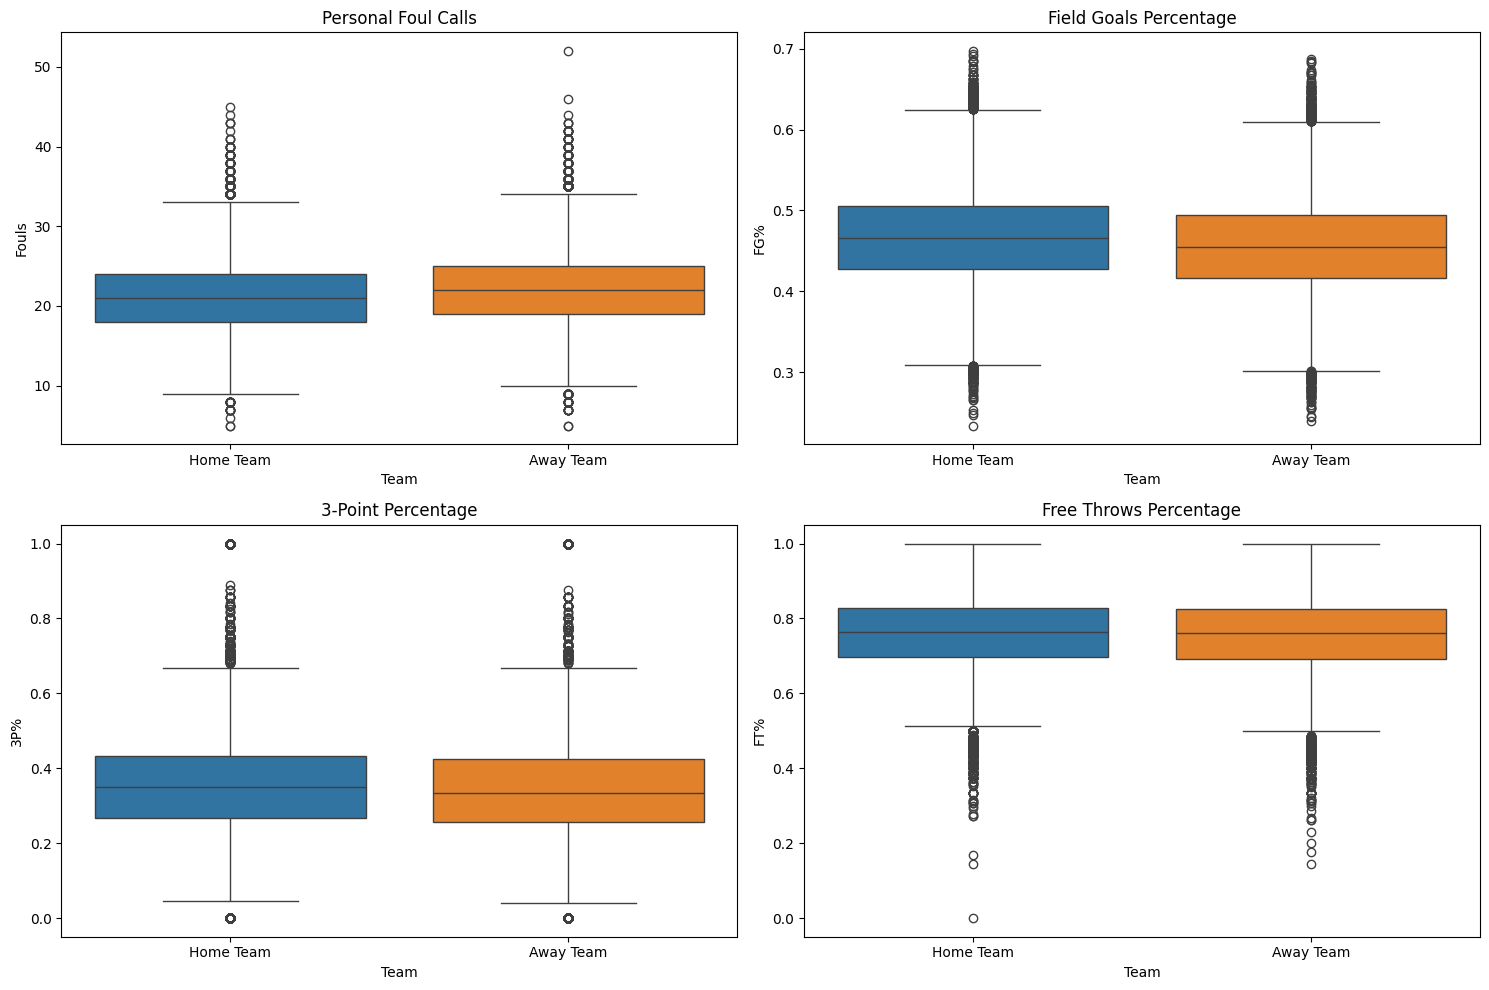

In [14]:
# Box Plots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

# Foul Calls
foul_data = pd.DataFrame({
    "Foul Count": pd.concat([home_statistics_df["foulsPersonal"], away_statistics_df["foulsPersonal"]], axis=0),
    "Team": ["Home Team"] * len(home_statistics_df["foulsPersonal"]) + ["Away Team"] * len(away_statistics_df["foulsPersonal"])
})

sns.boxplot(data=foul_data, x="Team", y="Foul Count", hue="Team", ax=ax[0])
ax[0].set_title("Personal Foul Calls")
ax[0].set_ylabel("Fouls")

# FG%
fg_data = pd.DataFrame({
    "FG%": pd.concat([home_statistics_df["fieldGoalsPercentage"], away_statistics_df["fieldGoalsPercentage"]], axis=0),
    "Team": ["Home Team"] * len(home_statistics_df["fieldGoalsPercentage"]) + ["Away Team"] * len(away_statistics_df["fieldGoalsPercentage"])
})

sns.boxplot(data=fg_data, x="Team", y="FG%", hue="Team", ax=ax[1])
ax[1].set_title("Field Goals Percentage")
ax[1].set_ylabel("FG%")

# 3P%
three_data = pd.DataFrame({
    "3P%": pd.concat([home_statistics_df["threePointersPercentage"], away_statistics_df["threePointersPercentage"]], axis=0),
    "Team": ["Home Team"] * len(home_statistics_df["threePointersPercentage"]) + ["Away Team"] * len(away_statistics_df["threePointersPercentage"])
})

sns.boxplot(data=three_data, x="Team", y="3P%", hue="Team", ax=ax[2])
ax[2].set_title("3-Point Percentage")
ax[2].set_ylabel("3P%")

# FT%
ft_data = pd.DataFrame({
    "FT%": pd.concat([home_statistics_df["freeThrowsPercentage"], away_statistics_df["freeThrowsPercentage"]], axis=0),
    "Team": ["Home Team"] * len(home_statistics_df["freeThrowsPercentage"]) + ["Away Team"] * len(away_statistics_df["freeThrowsPercentage"])
})

sns.boxplot(data=ft_data, x="Team", y="FT%", hue="Team", ax=ax[3])
ax[3].set_title("Free Throws Percentage")
ax[3].set_ylabel("FT%")


plt.tight_layout()
plt.show()

## Does the home team win more often than the away team?

To compare whether the home team wins more often than the away team, we will perform a Proportions Test. This test will help us determine if there is a significant difference in win rates between home and away teams. For this, we want to check whether the two populations - home and away teams - differ significantly with respect to their win rates.

To be able to perform such a test, we need to check its assumptions:
- The two samples are independent: Because in the original data, we have two rows per game (one for home / away team, respectively), this condition is not met. To fix this, we simply only take the home team entries.
- Binary outcome: The outcome variable is binary (win or lose).
- Binomial Distribution: The outcome variable is binomially distributed. This condition is met, because we have two possible outcomes (win or lose).

Our Hypothesis is the following:
- Null Hypothesis (H0): The home team does not win more often than the away team (p_home = p_away)
- Alternative Hypothesis (H1): The home team wins more often than the away team (p_home > p_away)

We choose alpha = 0.05.


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
# Calculate win and losses
total_games = len(home_statistics_df)
home_wins = home_statistics_df["win"].sum()
home_losses = total_games - home_wins

In [ ]:
# Perform test
h0 = 0.5
statistic, p_value = proportions_ztest(count=home_wins, nobs=total_games, value=h0, alternative="larger")
print(f"Z-statistic: {statistic}, p-value: {p_value}")

Z-statistic: 42.41894190351562, p-value: 0.0


We have a p-value of 0.0, which is less than the significance level of 0.05. Therefore, we reject the null hypothesis and conclude that the home team does indeed win more often than the away team.

## Does home team get more Fouls?

We use a similar approach as for the previous question. First generaly investigate if the home team has a higher proportion of fouls than when away. But here we want to compare the mean of the two distributions (home and away). For this reason we plan to apply a t-test.

First check if the assumptions hold
- normality (normal distributed)
- similar variance
- independent

For the same reason as above, we can already assume that they are independent.

Before we begin, let's create proper df's for this task

In [17]:
# how the data looks like
print(home_statistics_df["foulsPersonal"].describe())

# split into home and away
home_fouls_df = home_statistics_df["foulsPersonal"]
away_fouls_df = away_statistics_df["foulsPersonal"]

count    45542.000000
mean        21.179988
std          4.611438
min          5.000000
25%         18.000000
50%         21.000000
75%         24.000000
max         45.000000
Name: foulsPersonal, dtype: float64


And do the same EDA as before.

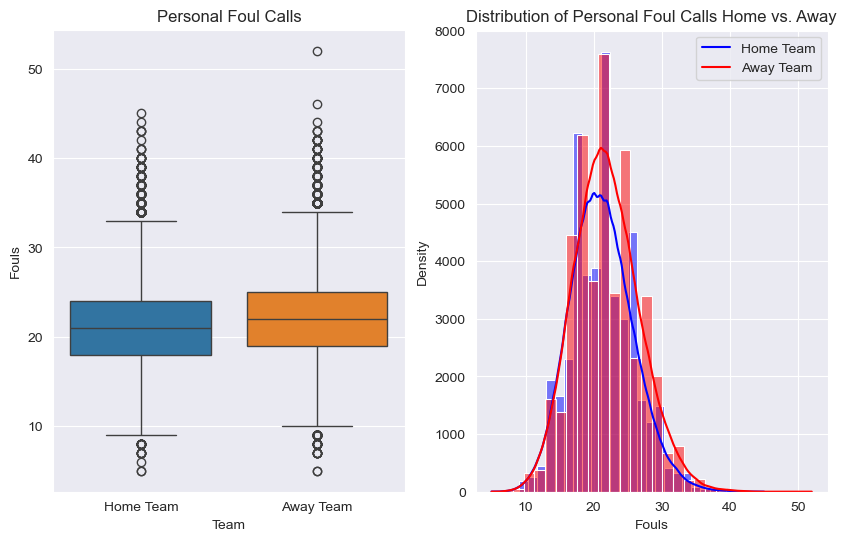

In [ ]:
# same as above
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Foul Calls - boxplot
foul_data = pd.DataFrame({
    "Foul Count": pd.concat([home_fouls_df, away_fouls_df], axis=0),
    "Team": ["Home Team"] * len(home_fouls_df) + ["Away Team"] * len(away_fouls_df)
})

sns.boxplot(data=foul_data, x="Team", y="Foul Count", hue="Team", ax=axs[0])
axs[0].set_title("Personal Foul Calls")
axs[0].set_ylabel("Fouls")

# Foul Calls - histogram
sns.histplot(home_fouls_df, bins=30, kde=True, color="blue", ax=axs[1])
sns.histplot(away_fouls_df, bins=30, kde=True, color="red", ax=axs[1])
axs[1].set_title("Distribution of Personal Foul Calls Home vs. Away")
axs[1].set_xlabel("Fouls")
axs[1].set_ylabel("Density")
axs[1].legend(["Home Team", "Away Team"])

Check normality assumption with qq plot

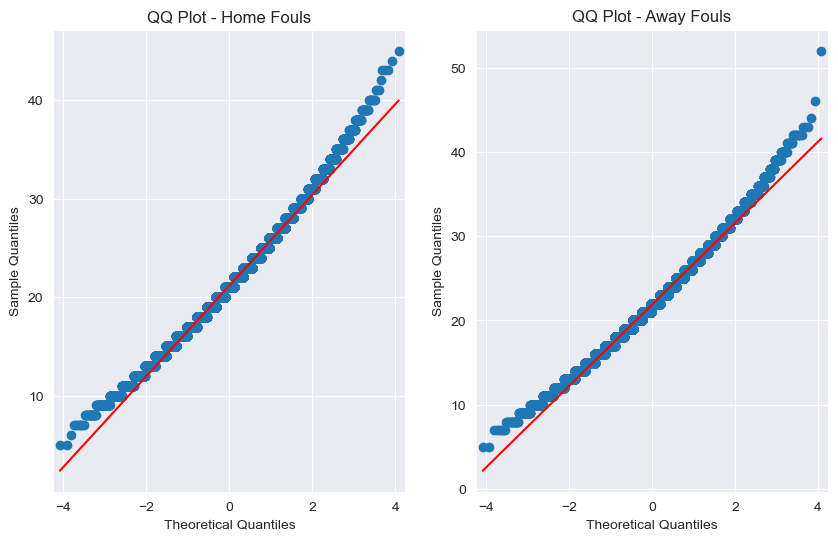

In [ ]:
from statsmodels.graphics.gofplots import qqplot

def fouls_qqplot(home_df, away_df):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))

    # qq plot for home games
    qqplot(home_df, line="s", ax=axs[0])
    axs[0].set_title("QQ Plot - Home Fouls")

    # qq plot for away games
    qqplot(away_df, line="s", ax=axs[1])
    axs[1].set_title("QQ Plot - Away Fouls")

    plt.show()

fouls_qqplot(home_fouls_df, away_fouls_df)

This looks fairly normal distributed. We thus assume it is.

Now check if variance is similar. for this we take the ratio of the variances.

In [ ]:
print(f"Variance ratio: {np.var(home_fouls_df) / np.var(away_fouls_df):.2f}")

Variance ratio: 0.91


variance is less than 4, so we can assume it's approximately equal (https://www.statology.org/t-test-assumptions/)

All assumptions are met. Thus we can continue with the t-test.

The null hypothesis would be:

- $H_0$​: There is no significant difference in the mean number of fouls committed by a team in home games compared to away games (i.e., $\mu_{home} = \mu_{away}$)
- We set $\alpha = 5\%$

In [ ]:
# print the means (for completeness, they are not actually used)
print(f"Mean home fouls: {home_fouls_df.mean():.2f}")
print(f"Mean away fouls: {away_fouls_df.mean():.2f}")

Mean home fouls: 21.17
Mean away fouls: 21.88


In [ ]:
# conduct the t test
from scipy.stats import ttest_ind

statistic, p_value = ttest_ind(home_fouls_df, away_fouls_df)
print(f"T-statistic: {statistic:.2f}, p-value: {p_value:.2f}", end="\n-----\n")

# interpret
alpha = 0.05
print(f"alpha: {alpha}")
if p_value > alpha:
	print("Same distributions (fail to reject H0)")
else:
	print("Different distributions (reject H0)")

T-statistic: -22.71, p-value: 0.00
-----
alpha: 0.05
Different distributions (reject H0)


## If the home team wins, does it win by a larger margin than if the away team wins?

We want to analyze whether if the home team wins, it wins by a larger margin than if the away team wins. Before, we have looked at if the home team wins more, but home court advantage may not materialize into a win. If the worst team in the league is playing at home against the best team, the home team will probably still lose, but they might lose by less than if they were playing away. Therefore, we want to analyze the point margins.

As a first step, we will look at the distribution of the point margins for home and away teams.

In [ ]:
# Select win and plusMinusPoints columns
home_margin_df = home_statistics_df[["win", "plusMinusPoints"]]
away_margin_df = away_statistics_df[["win", "plusMinusPoints"]]



In [ ]:
home_margin_df.head()

,win,plusMinusPoints
0,0,-30.0
1,1,10.0
2,0,-30.0
3,0,-1.0
4,0,-13.0


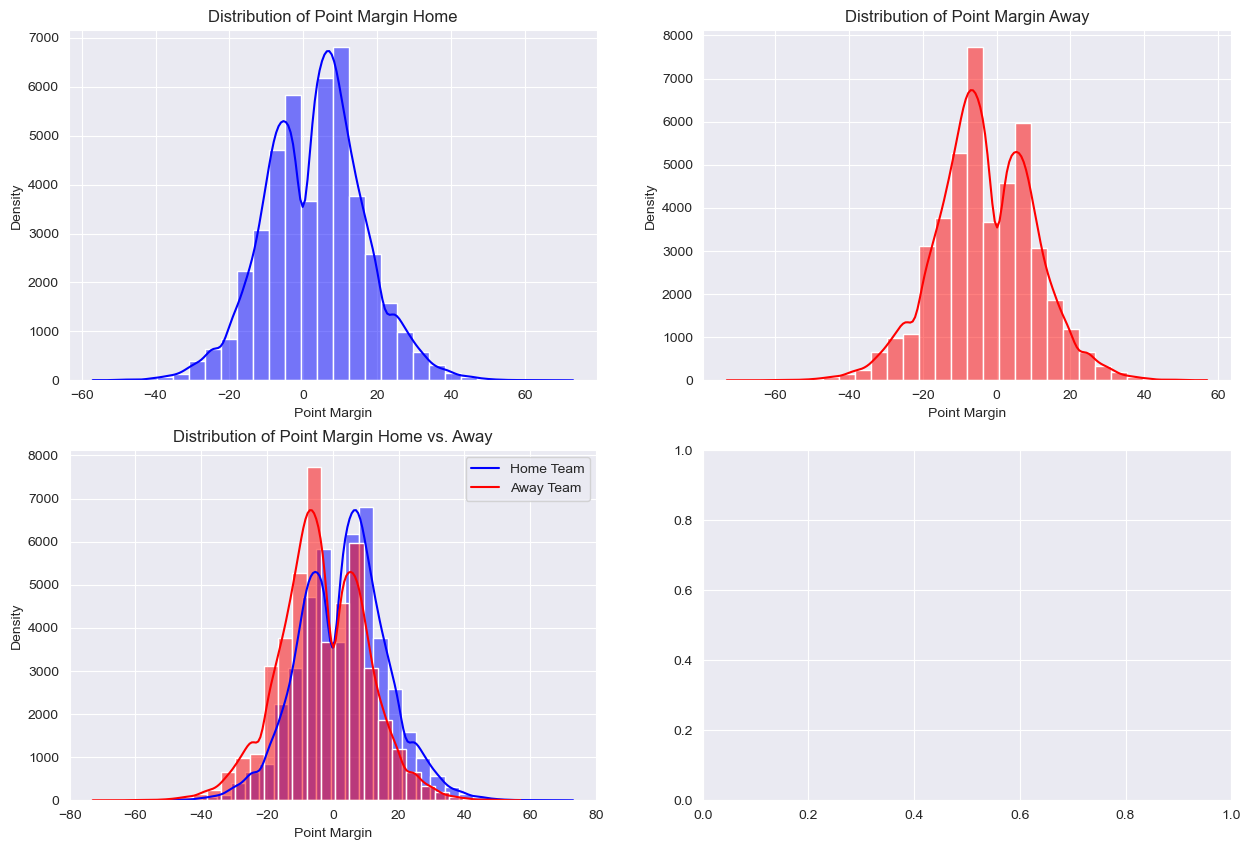

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
# Point margin distributions
sns.histplot(home_margin_df["plusMinusPoints"], bins=30, kde=True, color="blue", ax=axs[0])
axs[0].set_title("Distribution of Point Margin Home")
axs[0].set_xlabel("Point Margin")
axs[0].set_ylabel("Density")

sns.histplot(away_margin_df["plusMinusPoints"], bins=30, kde=True, color="red", ax=axs[1])
axs[1].set_title("Distribution of Point Margin Away")
axs[1].set_xlabel("Point Margin")
axs[1].set_ylabel("Density")

sns.histplot(home_margin_df["plusMinusPoints"], bins=30, kde=True, color="blue", ax=axs[2])
sns.histplot(away_margin_df["plusMinusPoints"], bins=30, kde=True, color="red", ax=axs[2])
axs[2].set_title("Distribution of Point Margin Home vs. Away")
axs[2].set_xlabel("Point Margin")
axs[2].set_ylabel("Density")
axs[2].legend(["Home Team", "Away Team"])
plt.show()

We can already observe that for both home and away teams we have a multimodal distribution. Since we have one entry for each the home and away team, the distributions are exactly mirrored around 0. We do observe that the higher of the two peaks for the home teams are in the positive margins, while the away teams have a higher peak in the negative margins. Since we are interested in wins for both sides, we only take the positive margins into account.

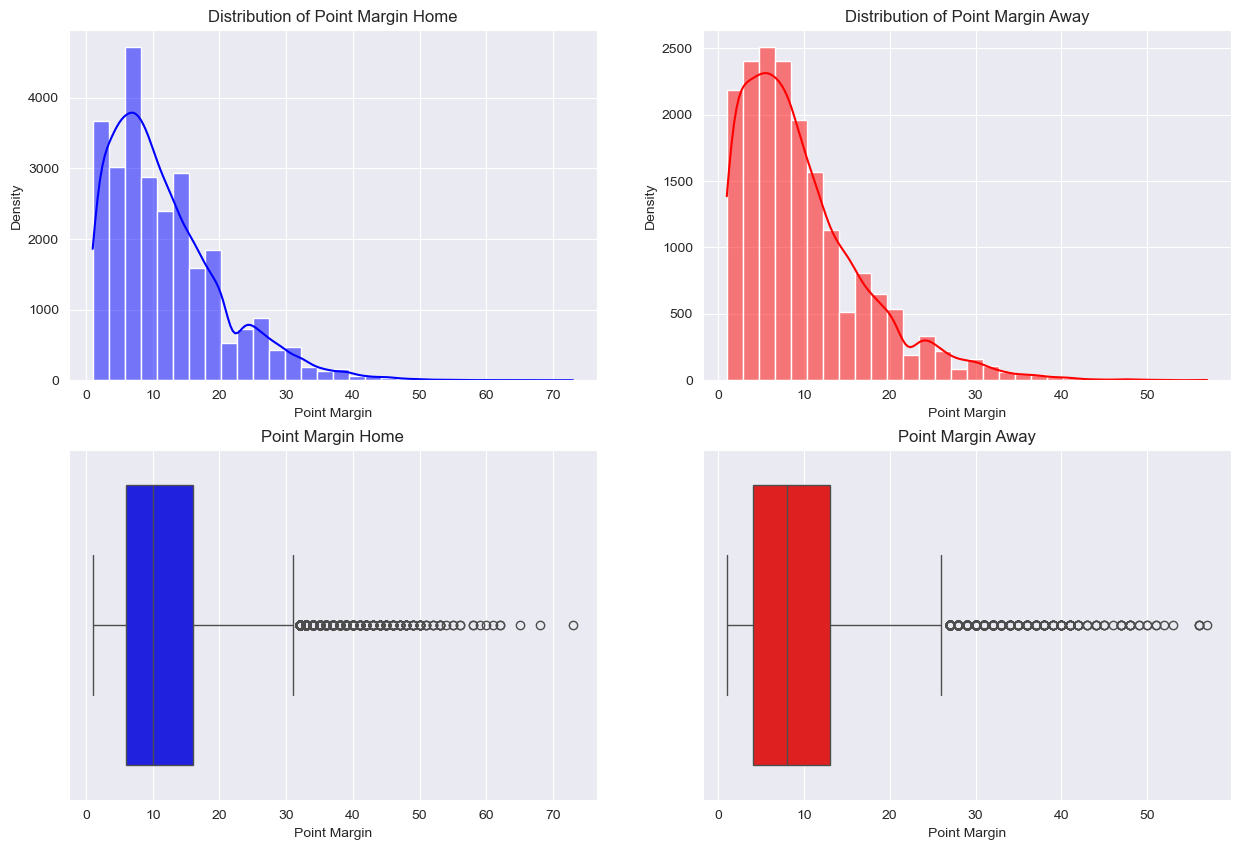

In [ ]:
home_margin_df = home_margin_df[home_margin_df["plusMinusPoints"] > 0]
away_margin_df = away_margin_df[away_margin_df["plusMinusPoints"] > 0]
home_margin_df.reset_index(drop=True, inplace=True)
away_margin_df.reset_index(drop=True, inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
# Point margin distributions
sns.histplot(home_margin_df["plusMinusPoints"], bins=30, kde=True, color="blue", ax=axs[0])
axs[0].set_title("Distribution of Point Margin Home")
axs[0].set_xlabel("Point Margin")
axs[0].set_ylabel("Density")
sns.histplot(away_margin_df["plusMinusPoints"], bins=30, kde=True, color="red", ax=axs[1])
axs[1].set_title("Distribution of Point Margin Away")
axs[1].set_xlabel("Point Margin")
axs[1].set_ylabel("Density")

# Box plots
sns.boxplot(data=home_margin_df, x="plusMinusPoints", color="blue", ax=axs[2])
axs[2].set_title("Point Margin Home")
axs[2].set_xlabel("Point Margin")
sns.boxplot(data=away_margin_df, x="plusMinusPoints", color="red", ax=axs[3])
axs[3].set_title("Point Margin Away")
axs[3].set_xlabel("Point Margin")

plt.show()

In [ ]:
home_margin_df.describe()

,win,plusMinusPoints
count,26790.000000,26790.000000
mean,0.999963,11.817320
std,0.006110,8.485127
min,0.000000,1.000000
25%,1.000000,6.000000
50%,1.000000,10.000000
75%,1.000000,16.000000
max,1.000000,73.000000


In [ ]:
away_margin_df.describe()

,win,plusMinusPoints
count,17987.0,17987.000000
mean,1.0,9.826653
std,0.0,7.362006
min,1.0,1.000000
25%,1.0,4.000000
50%,1.0,8.000000
75%,1.0,13.000000
max,1.0,57.000000


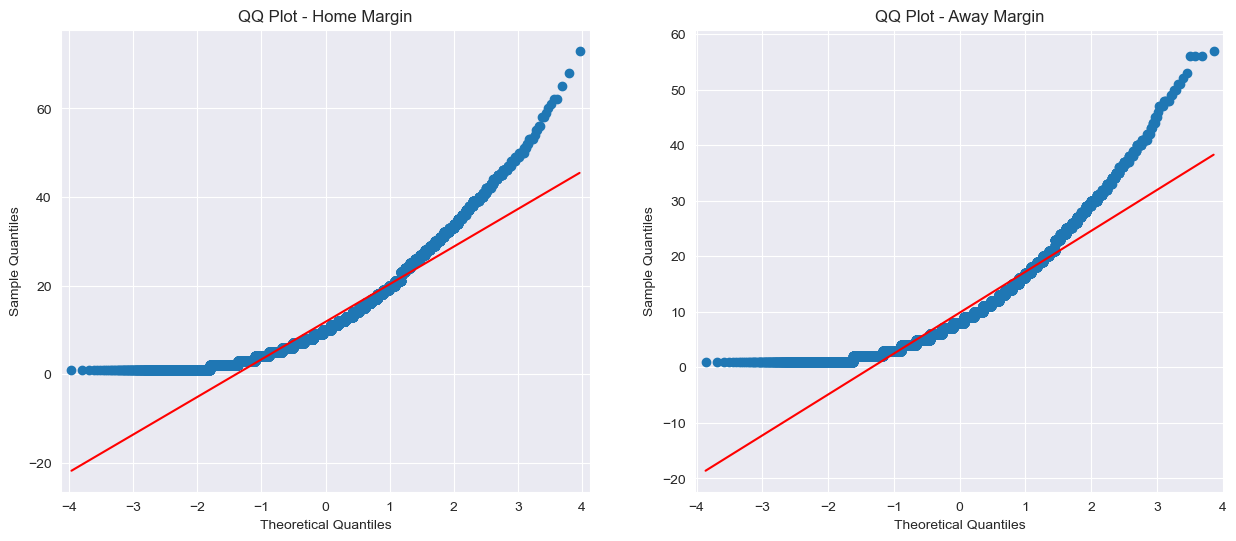

In [ ]:
# QQ Plot
from statsmodels.graphics.gofplots import qqplot

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
qqplot(home_margin_df["plusMinusPoints"], line="s", ax=axs[0])
axs[0].set_title("QQ Plot - Home Margin")
qqplot(away_margin_df["plusMinusPoints"], line="s", ax=axs[1])
axs[1].set_title("QQ Plot - Away Margin")
plt.show()

In [ ]:
# Shapiro Wilk test to test normality
from scipy.stats import shapiro

home_stat, home_p = shapiro(home_margin_df["plusMinusPoints"])
away_stat, away_p = shapiro(away_margin_df["plusMinusPoints"])
print(f"Home Margin: Statistic={home_stat:.3f}, p-value={home_p:.3f}")
print(f"Away Margin: Statistic={away_stat:.3f}, p-value={away_p:.3f}")

Home Margin: Statistic=0.904, p-value=0.000
Away Margin: Statistic=0.887, p-value=0.000


C:\Users\trist\miniconda3\envs\Intro_Data_Science_Project\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26790.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\trist\miniconda3\envs\Intro_Data_Science_Project\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17987.
  res = hypotest_fun_out(*samples, **kwds)


Both the QQ Plot and Shapiro-Wilk test suggest that the data is not normally distributed, so we cannot perform a t-test. Instead, we will be using the Mann-Whitney U test, which is a non-parametric test that does not assume normality.

- Null Hypothesis (H0): There is no difference in the distribution of winning margins between home and away teams.
- Alternative Hypothesis (H1): Home wins have a higher margin than away wins.

In [ ]:
def effect_size(U, n1, n2):
    """
    Calculate the effect size for a given U statistic in a Mann-Whitney U test.

    The effect size is calculated using the formula:
        r = Z / sqrt(N), where Z is the standardized U statistic and N is the total sample size.

    An effect size of 0.1 is considered small, 0.3 is medium, and 0.5 is large.

    :param U: U statistic from the Mann-Whitney U test
    :type U: float
    :param n1: Sample size of the first group
    :type n1: int
    :param n2: Sample size of the second group
    :type n2: int
    :return: Effect size (r), a measure of practical significance
    :rtype: float
    """
    mean_U = n1 * n2 / 2
    std_U = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)
    Z = (U - mean_U) / std_U
    N = n1 + n2
    r = Z / np.sqrt(N)
    return r

In [ ]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test
alpha = 0.05
statistic, p_value = mannwhitneyu(home_margin_df["plusMinusPoints"], away_margin_df["plusMinusPoints"], alternative="greater")

print(f"U-statistic: {statistic:.2f}, p-value: {p_value:.2f}", end="\n-----\n")
print(f"alpha: {alpha}")
if p_value > alpha:
    print("Same distributions (fail to reject H0)", end="\n-----\n")
else:
    print("Different distributions (reject H0)", end="\n-----\n")

# Calculate effect size
r = effect_size(statistic, len(home_margin_df), len(away_margin_df))
print(f"Effect Size {r:.2f}", end="\n-----\n")


U-statistic: 274895577.50, p-value: 0.00
-----
alpha: 0.05
Different distributions (reject H0)
-----
Effect Size 0.12
-----


We have a p-value of 0.0, which is less than the significance level of 0.05. Therefore, we reject the null hypothesis and conclude that the home team does win by a larger margin than the away team. We have received an effect size of 0.12, which means that though the test is significant, the practical effect is small. This means that the home team does win by a larger margin, but not by much.

Next up, we want to analyze whether there are any outlier teams that have a higher home court advantage than other teams. This could be down to multiple factors, such as having more fans in their arenas, having a better atmosphere etc.
First, we will look at what teams we have.


In [ ]:
teams = team_statistics_df["teamName"].unique()
teams

array(['Celtics', 'Suns', 'Nuggets', 'Bucks', 'Nets', 'Raptors', 'Lakers',
       'Pacers', 'Clippers', 'Knicks', '76ers', 'Wizards', 'Cavaliers',
       'Trail Blazers', 'Kings', 'Thunder', 'Jazz', 'Grizzlies', 'Hawks',
       'Rockets', 'Warriors', 'Heat', 'Mavericks', 'Magic', 'Hornets',
       'Spurs', 'Pistons', 'Bulls', 'Pelicans', 'Timberwolves', 'Bobcats',
       'SuperSonics', 'Bullets'], dtype=object)

Note that we have 33 unique teams, however there are only 30 teams in the NBA. This is because teams have rebranded themselves. For this analysis, we have decided to merge the teams together that have rebranded themselves. These include:
- Charlotte Bobcats -> Charlotte Hornets
- Seattle SuperSonics -> Oklahoma City Thunder
- New Orleans Hornets -> New Orleans Pelicans
- Washington Bullets -> Washington Wizards

Because there is this weird history that the original Charlotte Hornets moved to the New Orleans Hornets, which then rebranded to the New Orleans Pelicans, and the Charlotte Bobcats rebranded to the Charlotte Hornets, that we have to be careful about merging those names.

In [ ]:
team_statistics_merged_df = team_statistics_df.copy()
team_statistics_merged_df['gameDate'] = pd.to_datetime(team_statistics_merged_df['gameDate'])

# Rename the teams to their current name
team_statistics_merged_df.loc[
    (team_statistics_merged_df['teamName'] == 'Hornets') & (team_statistics_merged_df['gameDate'].dt.year < 2014),
    'teamName'
] = 'Pelicans'
team_statistics_merged_df.loc[team_statistics_merged_df['teamName'] == 'Bobcats', 'teamName'] = 'Hornets'
team_statistics_merged_df.loc[team_statistics_merged_df['teamName'] == 'SuperSonics', 'teamName'] = 'Thunder'
team_statistics_merged_df.loc[team_statistics_merged_df['teamName'] == 'Bullets', 'teamName'] = 'Wizards'

Teams sorted by Home Advantage Margin (Largest to Lowest):
             team  home_advantage
0         Nuggets        8.988470
1            Jazz        8.903029
2        Warriors        7.427167
3          Pacers        7.407943
4           Kings        7.315051
5         Thunder        7.311260
6   Trail Blazers        7.181647
7       Cavaliers        7.044211
8            Suns        6.586032
9           Spurs        6.457989
10        Wizards        6.410881
11          Magic        6.390960
12         Lakers        6.381240
13          Bucks        6.361226
14          Hawks        6.358517
15        Rockets        6.150821
16       Clippers        6.119286
17        Celtics        5.728595
18           Nets        5.724011
19           Heat        5.692903
20          Bulls        5.618597
21        Hornets        5.581488
22      Mavericks        5.572917
23        Pistons        5.503749
24          76ers        5.413825
25       Pelicans        5.316545
26      Grizzlies      

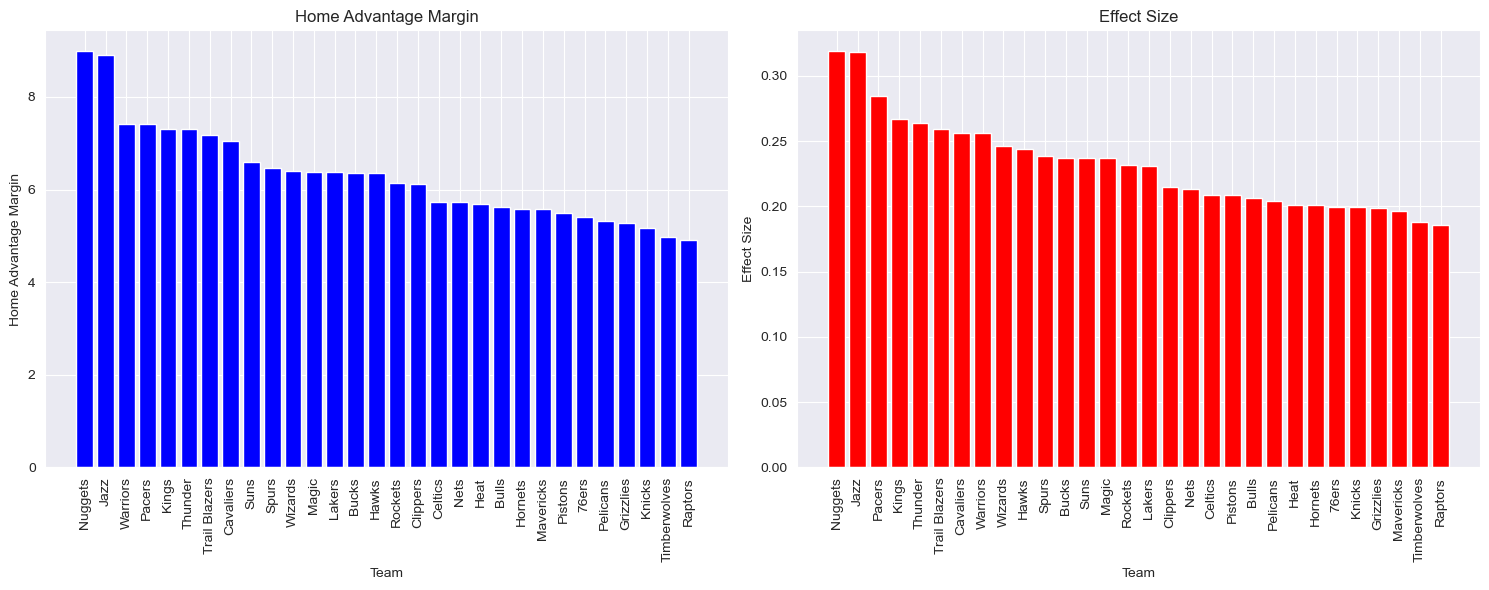

In [ ]:
from scipy.stats import mannwhitneyu

team_stats = []
teams = team_statistics_merged_df["teamName"].unique()

for team in teams:
    # Create df for team
    home_team_df = team_statistics_merged_df[(team_statistics_merged_df["teamName"] == team) & (team_statistics_merged_df["home"] == True)]
    away_team_df = team_statistics_merged_df[(team_statistics_merged_df["teamName"] == team) & (team_statistics_merged_df["home"] == False)]

    home_avg = home_team_df["plusMinusPoints"].mean()
    away_avg = away_team_df["plusMinusPoints"].mean()
    home_advantage = home_avg - away_avg

    # Perform U test
    statistic, p_value = mannwhitneyu(home_team_df["plusMinusPoints"], away_team_df["plusMinusPoints"], alternative="greater")

    # Calculate effect size
    n1 = len(home_team_df)
    n2 = len(away_team_df)
    r = effect_size(statistic, n1, n2)

    # Append results to list
    team_stats.append({
        "team": team,
        "home_avg": home_avg,
        "away_avg": away_avg,
        "home_advantage": home_advantage,
        "U-statistic": statistic,
        "p-value": p_value,
        "effect size": r
    })


# Convert to DataFrame
home_court_advantage_per_team_df = pd.DataFrame(team_stats)
home_court_advantage_per_team_df.sort_values(by="home_advantage", ascending=False, inplace=True)
home_court_advantage_per_team_df.reset_index(drop=True, inplace=True)

print("Teams sorted by Home Advantage Margin (Largest to Lowest):")
print(home_court_advantage_per_team_df[["team", "home_advantage"]])

sorted_by_effect = home_court_advantage_per_team_df.sort_values(by="effect size", ascending=False)
print("\n Teams sorted by Effect Size (Largest to Lowest)")
print(sorted_by_effect[["team", "effect size"]])

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].bar(home_court_advantage_per_team_df["team"], home_court_advantage_per_team_df["home_advantage"], color="blue")
axs[0].set_title("Home Advantage Margin")
axs[0].set_xlabel("Team")
axs[0].set_ylabel("Home Advantage Margin")
axs[0].tick_params(axis='x', rotation=90)
axs[1].bar(sorted_by_effect["team"], sorted_by_effect["effect size"], color="red")
axs[1].set_title("Effect Size")
axs[1].set_xlabel("Team")
axs[1].set_ylabel("Effect Size")
axs[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

There are two teams that standout as having a better home court advantage than the rest. they have seperated themselves in both the home advantage margin and effect size. These teams are:
- Denver Nuggets
- Utah Jazz

There arent any obvious negative outliers, but the lowest rated teams are:
- Toronto Raptors
- Minnesota Timberwolves

Since we are looking at point margin between home and away games, we can get a good impression of how much of a boost they get when playing at home vs away. Again, an effect size of 0.1 is considered small, 0.3 is medium, and 0.5 is large. Only the Denver Nuggets and Utah Jazz have achieved a medium effect size.

# Does the home team score on a higher percentage than the enemy

We use


In [19]:
# how the data looks like
cols = ["teamScore", "opponentScore"]
print(home_statistics_df[cols].describe())

# split into home and away
home_scores_df = home_statistics_df[cols]
away_scores_df = away_statistics_df[cols]

          teamScore  opponentScore
count  45542.000000   45542.000000
mean     104.387994     101.185455
std       13.738733      13.494477
min       49.000000      53.000000
25%       95.000000      92.000000
50%      104.000000     101.000000
75%      113.000000     110.000000
max      175.000000     176.000000


Text(0, 0.5, 'Opponent Score')

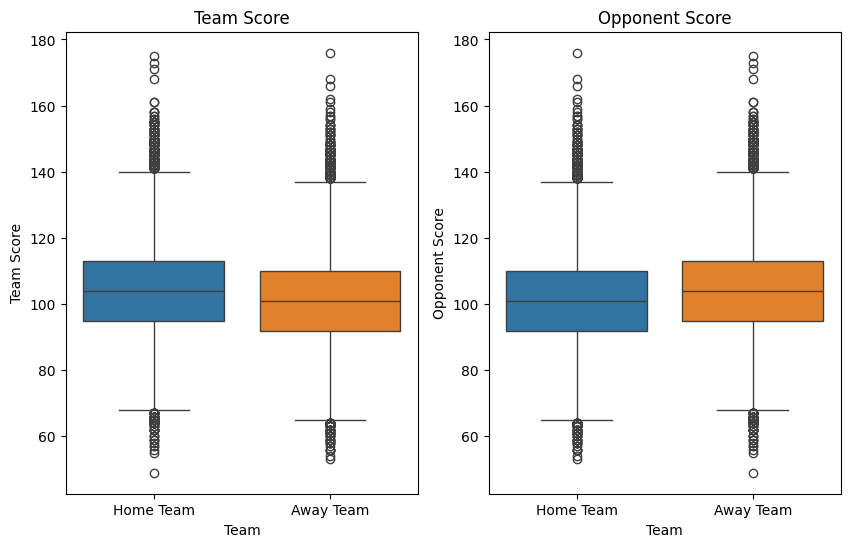

In [22]:
# boxplot of teamScore and opponent Score
# same as above
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# TeamScore and OpponentScore boxplot
score_data = pd.DataFrame({
    "TeamScore": pd.concat([home_scores_df["teamScore"], away_scores_df["teamScore"]], axis=0),
    "OpponentScore": pd.concat([home_scores_df["opponentScore"], away_scores_df["opponentScore"]], axis=0),
    "Team": ["Home Team"] * len(home_scores_df["teamScore"]) + ["Away Team"] * len(away_scores_df["teamScore"])
})

sns.boxplot(data=score_data, x="Team", y="TeamScore", hue="Team", ax=axs[0])
axs[0].set_title("Team Score")
axs[0].set_ylabel("Team Score")

sns.boxplot(data=score_data, x="Team", y="OpponentScore", hue="Team", ax=axs[1])
axs[1].set_title("Opponent Score")
axs[1].set_ylabel("Opponent Score")


of course they are symmetric... -> only look at one df

In [23]:
home_scores_df.describe()

,teamScore,opponentScore
count,45542.000000,45542.000000
mean,104.387994,101.185455
std,13.738733,13.494477
min,49.000000,53.000000
25%,95.000000,92.000000
50%,104.000000,101.000000
75%,113.000000,110.000000
max,175.000000,176.000000


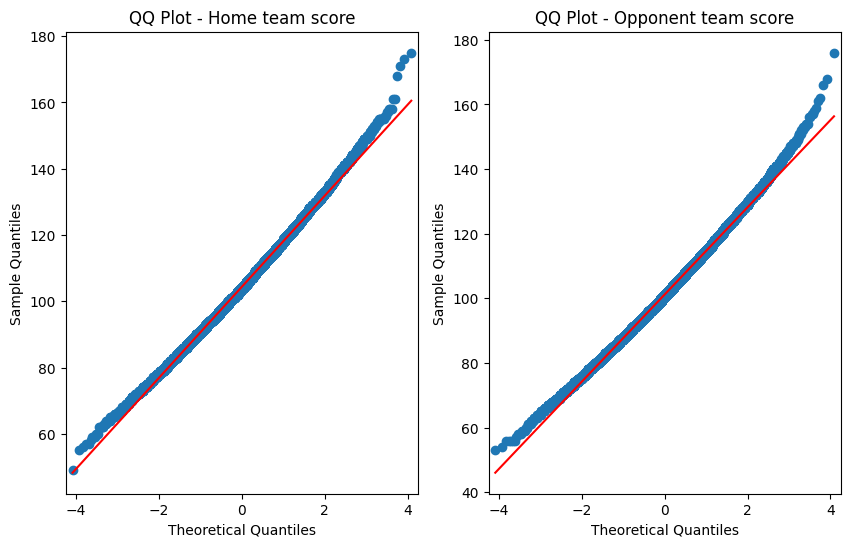

In [24]:
from statsmodels.graphics.gofplots import qqplot

def scores_qqplot(team, opponent):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))

    # qq plot for home games
    qqplot(team, line="s", ax=axs[0])
    axs[0].set_title("QQ Plot - Home team score")

    # qq plot for away games
    qqplot(opponent, line="s", ax=axs[1])
    axs[1].set_title("QQ Plot - Opponent team score")

    plt.show()

scores_qqplot(home_scores_df["teamScore"], home_scores_df["opponentScore"])

is normal

In [25]:
print(f"Variance ratio: {np.var(home_scores_df['teamScore']) / np.var(home_scores_df['opponentScore']):.2f}")

Variance ratio: 1.04


< 4, thus good

In [27]:
# print the means (for completeness, they are not actually used)
print(f"Mean home scores: {home_scores_df['teamScore'].mean():.2f}")
print(f"Mean away scores: {home_scores_df['opponentScore'].mean():.2f}")

Mean home scores: 104.39
Mean away scores: 101.19


The null hypothesis would be:

- $H_0$​: There is no significant difference in the mean number of scores of the team and the opponent (i.e., $\mu_{homeTeamScore} = \mu_{opponentScore}$)
- We set $\alpha = 5\%$

In [28]:
# conduct the t test
from scipy.stats import ttest_ind

statistic, p_value = ttest_ind(home_scores_df["teamScore"], home_scores_df["opponentScore"])
print(f"T-statistic: {statistic:.2f}, p-value: {p_value:.2f}", end="\n-----\n")

# interpret
alpha = 0.05
print(f"alpha: {alpha}")
if p_value > alpha:
	print("Same distributions (fail to reject H0)")
else:
	print("Different distributions (reject H0)")

T-statistic: 35.49, p-value: 0.00
-----
alpha: 0.05
Different distributions (reject H0)
